<a href="https://colab.research.google.com/github/sahil3Vedi/Human-Pose-Estimation-OpenCV/blob/main/Human_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To use Inference Engine backend, specify location of plugins:
# export LD_LIBRARY_PATH=/opt/intel/deeplearning_deploymenttoolkit/deployment_tools/external/mklml_lnx/lib:$LD_LIBRARY_PATH
import cv2 as cv
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_DIR = 'drive/My Drive/Human Pose Estimation'
OPT_PATH = os.path.join(DATA_DIR,'graph_opt.pb')

net = cv.dnn.readNetFromTensorflow(OPT_PATH) #weights

inWidth = 368
inHeight = 368
thr = 0.2

In [3]:
BODY_PARTS = { 
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 
}

POSE_PAIRS = [ 
              ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] 
]

In [4]:
#255/2 = 127.5

def pose_estimation(frame):
  frameWidth = frame.shape[1]
  frameHeight = frame.shape[0]
  net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5,127.5,127.5), swapRB=True, crop=False))

  out = net.forward()
  out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

  assert(len(BODY_PARTS) == out.shape[1])

  points = [] #list of points

  for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
        
  for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)
    
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    
    if points[idFrom] and points[idTo]:
      cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
      cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
      cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    final_frame = frame
    
  return final_frame



In [19]:
names = ['asif.jpg','bumrah.jpg','cathryn.jpg','henry.jpg','pak.jpg','steyn.jpg']
num_names = len(os.pathconf_names)

def plotImage(imgIndex):
  IMG_PATH = os.path.join(DATA_DIR,names[imgIndex])
  img = cv.imread(IMG_PATH)
  estimated_image = pose_estimation(img)
  plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

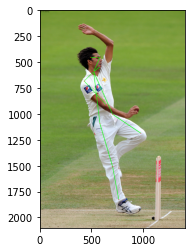

In [20]:
plotImage(0)

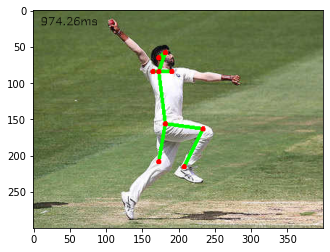

In [21]:
plotImage(1)

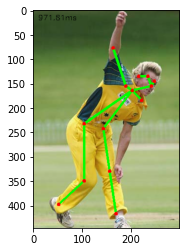

In [22]:
plotImage(2)

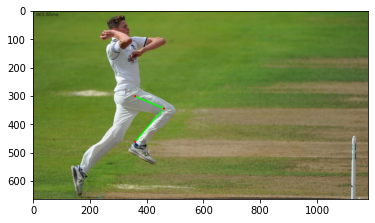

In [23]:
plotImage(3)

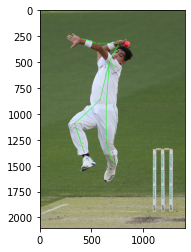

In [24]:
plotImage(4)

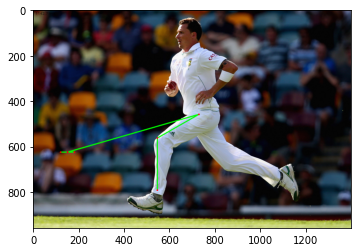

In [25]:
plotImage(5)